In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
# import pyedflib
import os
import glob
# import tensorflow as tf
from tqdm import tqdm
from lxml import etree
from sklearn.model_selection import train_test_split
import random
import multiprocessing as mp
from scipy import signal
import neurokit2 as nk
import pywt
import wfdb
import wfdb.processing


# Setup

In [2]:
BASE_DB_PATH = '/mnt/dat/databases/shhs/polysomnography'
TO_PATH = '/mnt/dat/prepped/automated_sleep_apnea'
os.makedirs(TO_PATH, exist_ok=True)

TARGET_SAMPLING_RATE = 5

SEGMENT_LENGTH = 30 # input to model
SINGLE_ANNOT = 30 # annotate for every N second
SEGMENT_STRIDE = 1 # second

HALF_SEGMENTS = (SEGMENT_LENGTH // SINGLE_ANNOT) // 2

SAMPLE_RECORD = 'shhs2-200078'

SMALL_PORTION = 1 # get small portion of train/validation for debugging or tuning, 1 to ignore

# consider only below channels
SELECTED_CHANNELS = ['ABDO RES', 'THOR RES', # resp signals
                     'ECG'] # to get EDR (ECG derived resp signal)

In [3]:
shhs1_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs1/*.edf'))
shhs2_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs2/*.edf'))
shhs1_edfs = sorted(shhs1_edfs) # only get samples
shhs2_edfs = sorted(shhs2_edfs)

len(shhs1_edfs), len(shhs2_edfs)

(5793, 2651)

In [4]:
shhs1_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs1/*.xml'))
shhs2_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs2/*.xml'))
shhs1_xmls = sorted(shhs1_xmls)
shhs2_xmls = sorted(shhs2_xmls)

len(shhs1_xmls), len(shhs2_xmls)

(5793, 2651)

# Examine a sample record

In [5]:
def get_edf(path, channels, split_ecg=False, preload=False):
    if split_ecg:
        resp_edf = mne.io.read_raw_edf(path, include=[c for c in channels if c != "ECG"], 
                                verbose=False, preload=preload)
        ecg_edf = mne.io.read_raw_edf(path, include=["ECG"], 
                                verbose=False, preload=preload)
        return resp_edf, ecg_edf

    return mne.io.read_raw_edf(path, include=channels, 
                                verbose=False, preload=preload)

In [6]:
resp_edf, ecg_edf = get_edf([s for s in shhs1_edfs +  shhs2_edfs if SAMPLE_RECORD in s[s.rfind("/")+1:]][0], 
                            channels=SELECTED_CHANNELS, 
                            split_ecg=True,
                            preload=True)
display(resp_edf)
display(ecg_edf)

<RawEDF | shhs2-200078.edf, 2 x 333000 (33299.9 s), ~5.1 MB, data loaded>

<RawEDF | shhs2-200078.edf, 1 x 8325000 (33300.0 s), ~63.5 MB, data loaded>

In [7]:
def random_window(array, window_size, axis=-1):
    if window_size > array.shape[axis]:
        raise ValueError("Window size must be smaller than or equal to the size of the specified axis.")
    
    start_index = np.random.randint(0, array.shape[axis] - window_size + 1)
    
    slices = [slice(None)] * array.ndim
    slices[axis] = slice(start_index, start_index + window_size)
    
    # Use slicing to extract the random window
    return array[tuple(slices)].copy(), start_index

300


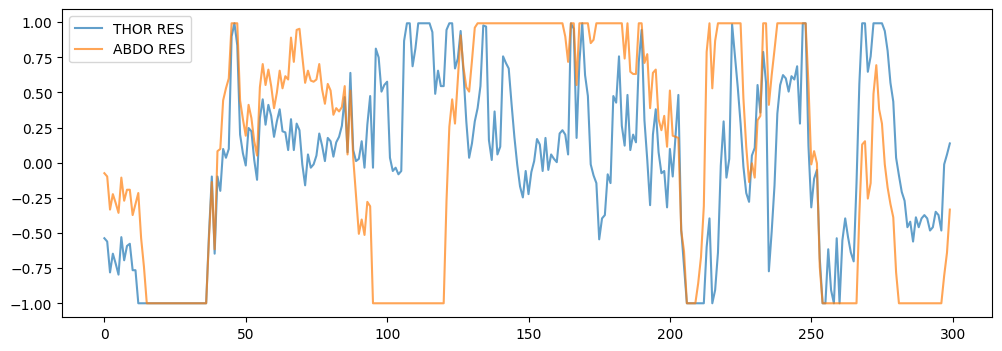

In [8]:
dataa1, _ = random_window(resp_edf.get_data(), window_size=int(30 * resp_edf.info['sfreq']))
print(dataa1.shape[1])
plt.figure(figsize=(12, 4))
sns.lineplot(dataa1[0], label=resp_edf.ch_names[0], alpha=0.7)
sns.lineplot(dataa1[1], label=resp_edf.ch_names[1], alpha=0.7)
plt.show()

7500


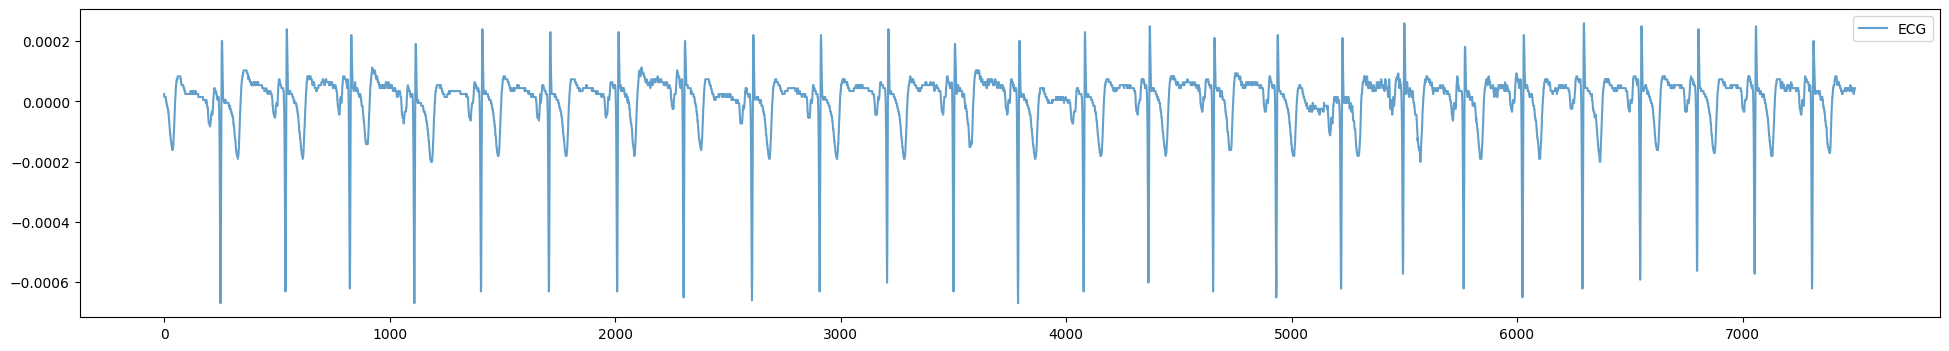

In [9]:
dataa1, _ = random_window(ecg_edf.get_data(), window_size=int(30 * ecg_edf.info['sfreq']))
print(dataa1.shape[1])
plt.figure(figsize=(24, 4))
sns.lineplot(dataa1[0], label=ecg_edf.ch_names[0], alpha=0.7)
plt.show()

# Read annotation

In [10]:
import logging
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def create_annotation(xml_path, start_date, selected_channels=None):
    # Use lxml's fast parser
    parser = etree.XMLParser(remove_blank_text=True, collect_ids=False)
    
    # Use xpath for direct access to elements
    try:
        tree = etree.parse(xml_path, parser)
    except (etree.XMLSyntaxError, OSError) as e:
        raise ValueError(f"Error parsing XML file: {e}")
    
    onset = []
    duration = []
    description = []
    if selected_channels is not None:
        ch_names = []
    
    for event in tree.xpath(".//ScoredEvent"):
        event_name = event.find('EventConcept').text
        if selected_channels is not None:
            ch_name = event.find('SignalLocation')
            if ch_name is None:
                ch_name = []
            elif ch_name.text in selected_channels:
                ch_name = [ch_name.text]
            else:
                ch_name = [] # or ignore by continue

        try:
            start_time = float(event.findtext('Start', default="0.0"))
            sduration = float(event.findtext('Duration', default="0.0"))
        except ValueError:
            logger.warning(f"Invalid start time or duration in event: {etree.tostring(event, pretty_print=True).decode()}")
            continue
        
        onset.append(start_time)
        duration.append(sduration)
        description.append(event_name)
        if selected_channels is not None:
            ch_names.append(ch_name)
    return mne.Annotations(onset=onset, duration=duration, description=description, 
                           ch_names=ch_names if selected_channels is not None else None, # ignore ch_names in annot if not specify
                           orig_time=start_date)

In [11]:
anott = create_annotation([s for s in shhs1_xmls + shhs2_xmls if SAMPLE_RECORD in s][0], resp_edf.info['meas_date'])

resp_edf = resp_edf.set_annotations(anott, emit_warning=False)
ecg_edf = ecg_edf.set_annotations(anott, emit_warning=False)

anott.to_data_frame()

,onset,duration,description
0,1985-01-01 23:15:00.000,1980.0,Wake|0
1,1985-01-01 23:15:00.000,33300.0,Recording Start Time
2,1985-01-01 23:23:48.000,10.0,SpO2 artifact|SpO2 artifact
3,1985-01-01 23:25:51.000,5.0,SpO2 artifact|SpO2 artifact
4,1985-01-01 23:26:50.000,11.0,SpO2 artifact|SpO2 artifact
...,...,...,...
604,1985-01-02 07:52:35.000,5.0,SpO2 artifact|SpO2 artifact
605,1985-01-02 07:52:50.000,3.0,SpO2 artifact|SpO2 artifact
606,1985-01-02 07:52:55.800,606.2,SpO2 artifact|SpO2 artifact
607,1985-01-02 08:03:02.000,1200.0,SpO2 artifact|SpO2 artifact


# Preprocess

## Extract EDR from ECG

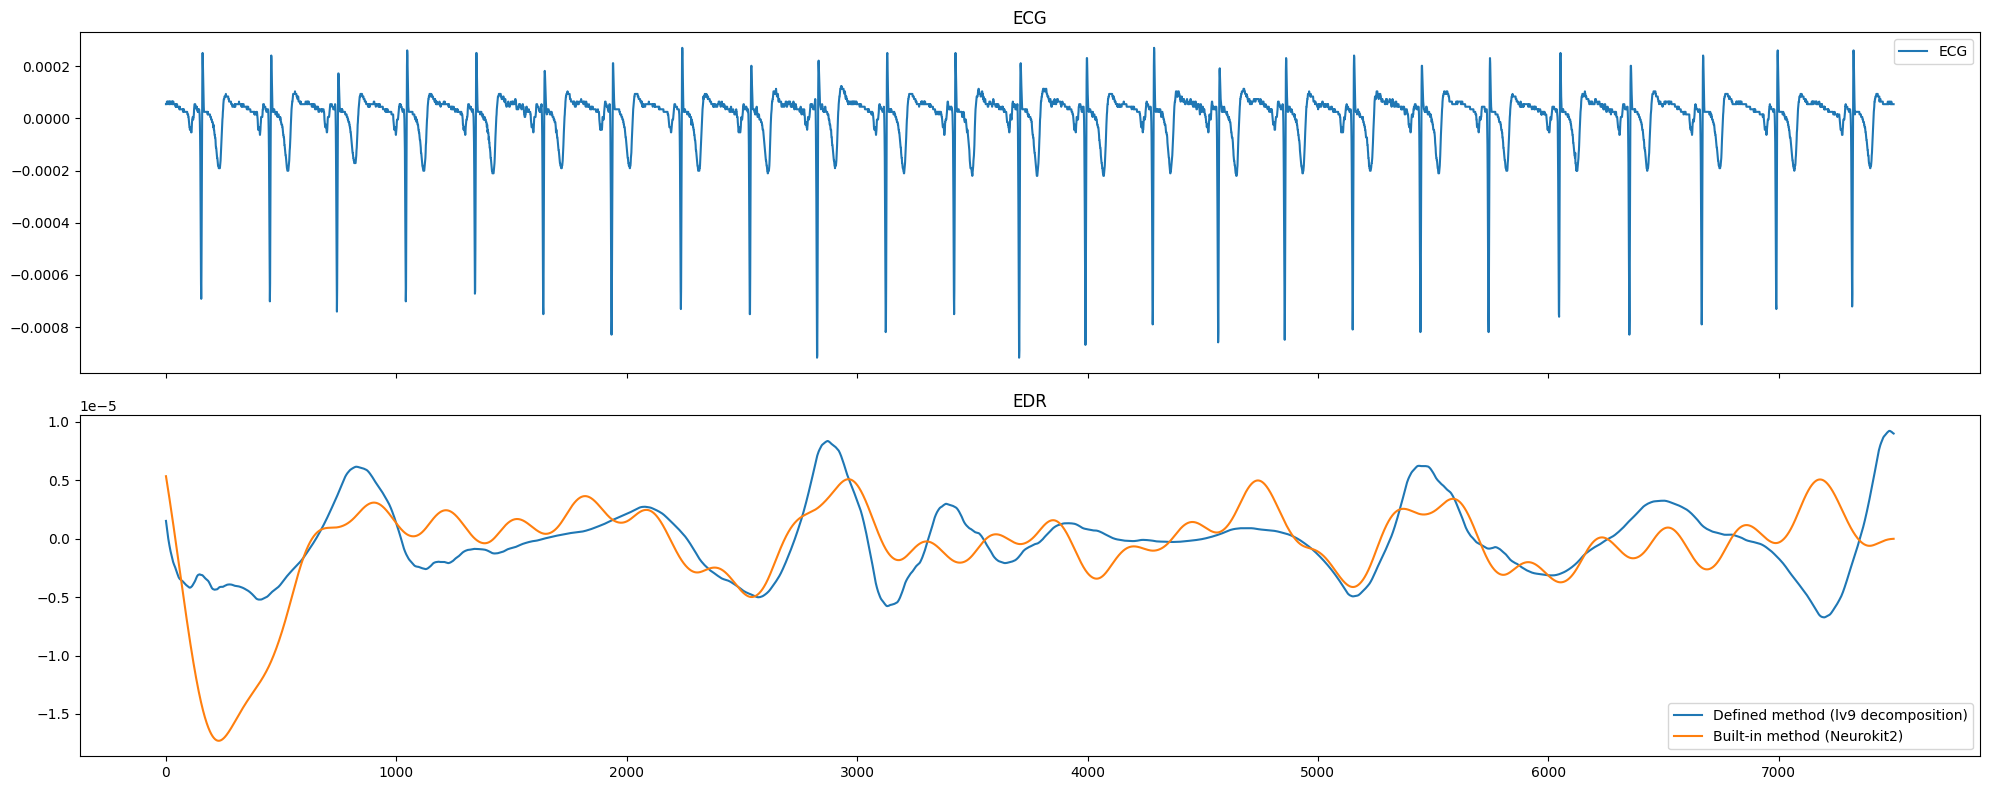

In [12]:
def extract_respiratory_signal(ecg_signal, wavelet='db4', level=9):
    """
    Extract respiratory signal from ECG using Discrete Wavelet Transform
    
    Parameters:
    - ecg_signal: Input ECG signal
    - wavelet: Wavelet type (default: Daubechies 4)
    - level: Decomposition level (default: 9)
    
    Returns:
    - respiratory_signal: Reconstructed respiratory signal
    - decomposition_coeffs: Full wavelet decomposition coefficients
    """
    # Perform Discrete Wavelet Transform
    decomposition_coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    
    # Create a copy of decomposition coefficients for reconstruction
    reconstructed_coeffs = [np.zeros_like(coeff) for coeff in decomposition_coeffs]
    
    # Copy only the detail coefficient at level 9
    reconstructed_coeffs[1] = decomposition_coeffs[1]

    # Reconstruct the signal using the modified coefficients
    respiratory_signal = pywt.waverec(reconstructed_coeffs, wavelet)
    
    return respiratory_signal


fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 8))

ecg_data, _ = random_window(ecg_edf.get_data()[0], window_size=int(30 * ecg_edf.info['sfreq']))
sns.lineplot(ecg_data, ax=axes[0], label='ECG')

axes[0].set_title("ECG")
edr = extract_respiratory_signal(ecg_data, wavelet='db4')
sns.lineplot(edr, ax=axes[1], label='Defined method (lv9 decomposition)')

axes[1].set_title("EDR")
edr1 = nk.ecg_rsp(ecg_data, sampling_rate=ecg_edf.info['sfreq'])
sns.lineplot(edr1, ax=axes[1], label='Built-in method (Neurokit2)')

fig.tight_layout()
plt.show()

In [13]:
# apply to whole signal
edr_og = extract_respiratory_signal(ecg_edf.get_data()[0])
edr_og.shape

(8325000,)

## Put EDR to Resp signals

### Resample to match with ABDO RES and THOR RES

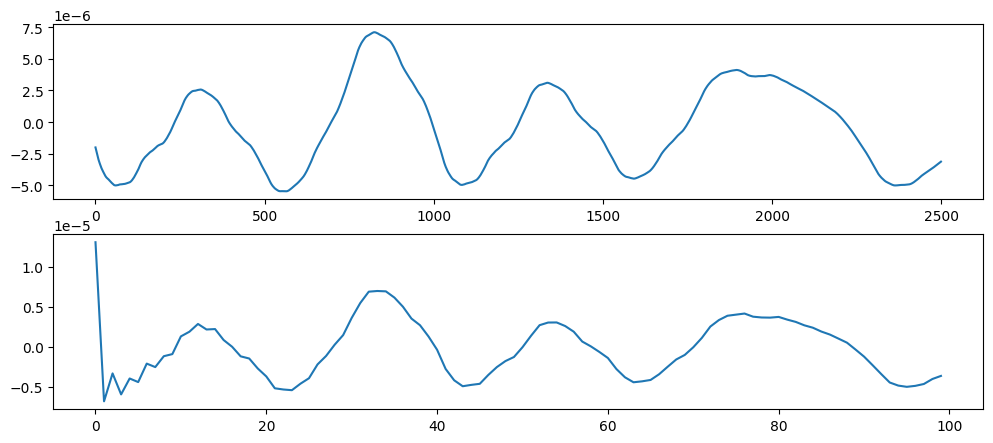

((333000,), np.int64(333000))

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 5))
sns.lineplot(edr_og[:2500], ax=axes[0])

edr, _ = wfdb.processing.resample_sig(edr_og, fs=ecg_edf.info['sfreq'], fs_target=resp_edf.info['sfreq'])

sns.lineplot(edr[:100], ax=axes[1])

plt.show()
edr.shape, resp_edf.n_times

In [15]:
def add_channel_to_raw(raw, new_channel_data, channel_name, channel_type):
    """
    Add a new channel to an existing mne.Raw object.

    Parameters:
    - raw (mne.io.Raw): The original Raw object.
    - new_channel_data (numpy.ndarray): The data for the new channel (shape: (n_samples,)).
    - channel_name (str): The name of the new channel.
    - channel_type (str): The type of the new channel (e.g., 'ecg', 'eog', 'misc').

    Returns:
    - mne.io.Raw: The Raw object with the new channel added.
    """
    
    if len(new_channel_data) != raw.n_times:
        raise ValueError("new_channel_data must have the same number of samples as the existing Raw data.")

    new_info = mne.create_info([channel_name], sfreq=raw.info['sfreq'], ch_types=[channel_type])

    # Reshape the new channel data to (n_channels, n_times)
    new_channel_data = new_channel_data[np.newaxis, :]

    # Create a RawArray for the new channel
    new_raw = mne.io.RawArray(new_channel_data, new_info, verbose=False)

    # Add the new channel to the existing Raw object
    raw.add_channels([new_raw])

    return raw

resp_edf = add_channel_to_raw(resp_edf, edr, "EDR", resp_edf.info.get_channel_types()[0])
resp_edf

<RawEDF | shhs2-200078.edf, 3 x 333000 (33299.9 s), ~7.6 MB, data loaded>

## Filter

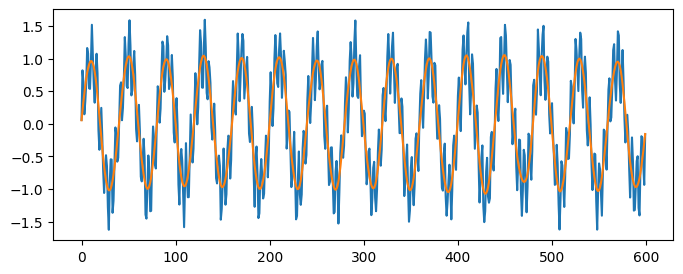

In [16]:
def butterworth_lowpass_filter(data, sampling_rate, cutoff_freq=0.7):
    """
    Apply a fourth-order low-pass zero-phase-shift Butterworth filter.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input signal to be filtered
    cutoff_freq : float
        Cut-off frequency in Hz
    sampling_rate : float
        Sampling rate of the input signal in Hz
    
    Returns:
    --------
    numpy.ndarray
        Filtered signal
    """
    # Nyquist frequency
    nyquist_freq = 0.5 * sampling_rate
    
    # Normalize the cutoff frequency
    normal_cutoff = cutoff_freq / nyquist_freq
    
    # Design the Butterworth filter
    b, a = signal.butter(N=4,  # 4th order
                         Wn=normal_cutoff,  # normalized cutoff frequency
                         btype='low',  # low-pass filter
                         analog=False)  # digital filter
    
    # Apply the filter forward and backward to create zero-phase shift
    filtered_signal = signal.filtfilt(b, a, data)
    
    return filtered_signal


# Simulate a respiratory signal
sampling_rate = 10  # Hz
time = np.linspace(0, 60, 600)  # 60 seconds of data

# Create a sample respiratory signal with noise
respiratory_signal = (
    np.sin(2 * np.pi * 0.25 * time) +  # Respiratory rate ~0.25 Hz
    0.5 * np.sin(2 * np.pi * 2 * time) +  # High-frequency noise
    np.random.normal(0, 0.1, time.shape)  # Random noise
)

# Apply the Butterworth filter
filtered_signal = butterworth_lowpass_filter(
    respiratory_signal, 
    sampling_rate=sampling_rate,
    cutoff_freq=0.7,  # Cut-off at 0.7 Hz 
)

plt.figure(figsize=(8, 3))
plt.plot(respiratory_signal)
plt.plot(filtered_signal)
plt.show()

In [17]:
rawdata = resp_edf.get_data().copy()

processed_data = np.apply_along_axis(lambda x: butterworth_lowpass_filter(x, sampling_rate=int(resp_edf.info['sfreq']), cutoff_freq=0.7), 
                                     axis=1, arr=rawdata)

resp_edf._data = processed_data

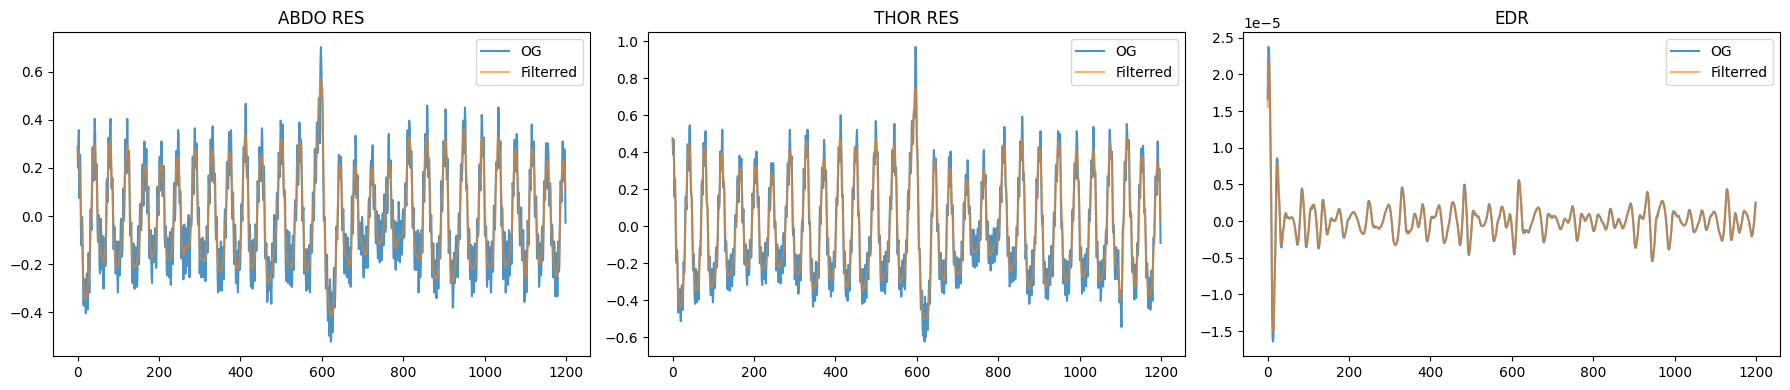

In [18]:
sample_length = int(resp_edf.info['sfreq'] * 120)
random_segment, index = random_window(rawdata, window_size=sample_length)
processed_segment = processed_data[:, index:(index + sample_length)]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharex=True)

axes[0].set_title("ABDO RES")
axes[1].set_title("THOR RES")
axes[2].set_title("EDR")

sns.lineplot(random_segment[0], ax=axes[0], label='OG', alpha=0.8)
sns.lineplot(random_segment[1], ax=axes[1], label='OG', alpha=0.8)
sns.lineplot(random_segment[2], ax=axes[2], label='OG', alpha=0.8)

sns.lineplot(processed_segment[0], ax=axes[0], label='Filterred', alpha=0.6)
sns.lineplot(processed_segment[1], ax=axes[1], label='Filterred', alpha=0.6)
sns.lineplot(processed_segment[2], ax=axes[2], label='Filterred', alpha=0.6)

fig.tight_layout()

plt.show()

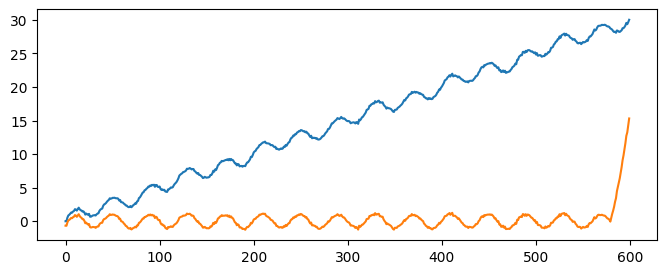

In [19]:
def remove_motion_artifacts(signal_data, sampling_rate, window_width=4):
    """
    Remove motion artifacts and baseline wander by subtracting a moving average 
    filtered signal from the original signal.
    
    Parameters:
    -----------
    signal_data : numpy.ndarray
        Original input signal
    sampling_rate : float
        Sampling rate of the signal (Hz)
    window_width : float, optional
        Width of the moving average window in seconds (default is 4 seconds)
    
    Returns:
    --------
    numpy.ndarray
        Signal with motion artifacts and baseline wander removed
    """
    # Calculate the window size in samples
    window_size = int(window_width * sampling_rate)
    
    # Ensure window size is odd for symmetric filtering
    if window_size % 2 == 0:
        window_size += 1
    
    # Create moving average filter kernel
    moving_average_kernel = np.ones(window_size) / window_size
    
    # Apply moving average filter to the signal
    moving_average_signal = np.convolve(
        signal_data, 
        moving_average_kernel, 
        mode='same'
    )
    
    # Subtract moving average from original signal
    artifact_removed_signal = signal_data - moving_average_signal
    
    return artifact_removed_signal


sampling_rate = 10  # Hz
time = np.linspace(0, 60, 600)  # 60 seconds 
original_signal = (
    np.sin(2 * np.pi * 0.25 * time) + 
    0.5 * time +  # Baseline wander (linear drift)
    0.3 * np.sin(2 * np.pi * 0.1 * time) +  # Low-frequency motion artifact
    np.random.normal(0, 0.1, time.shape)  # Random noise
)

# Remove motion artifacts
cleaned_signal = remove_motion_artifacts(
    original_signal, 
    sampling_rate=sampling_rate,
    window_width=4  # 4-second moving average window
)

plt.figure(figsize=(8, 3))
plt.plot(original_signal)
plt.plot(cleaned_signal)
plt.show()

In [20]:
rawdata = resp_edf.get_data().copy()

processed_data = np.apply_along_axis(lambda x: remove_motion_artifacts(x, sampling_rate=int(resp_edf.info['sfreq']), window_width=4), 
                                     axis=1, arr=rawdata)

resp_edf._data = processed_data

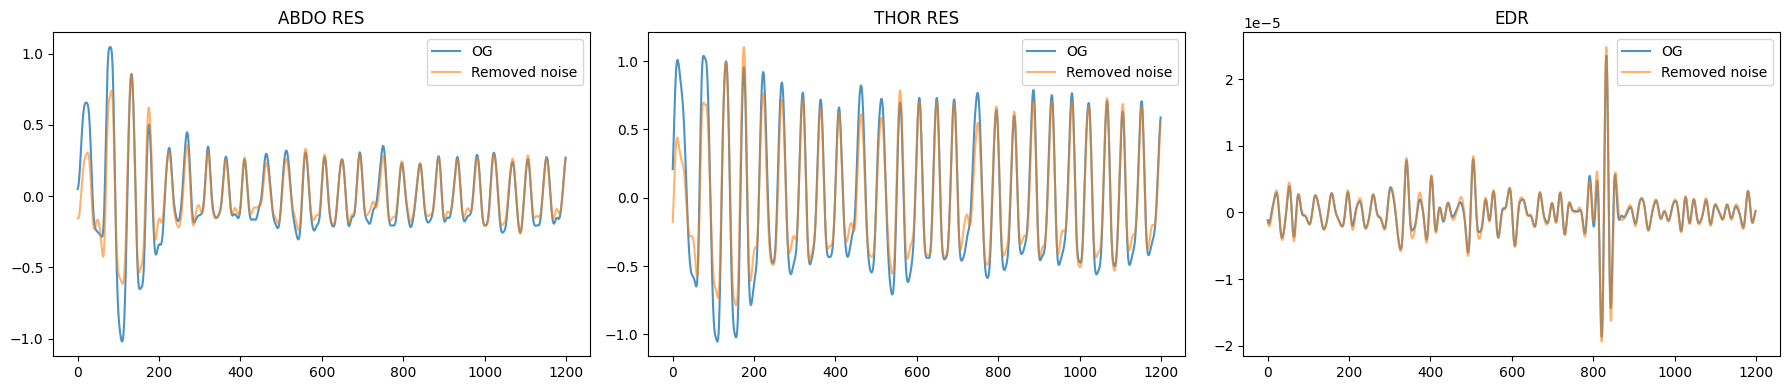

In [21]:
sample_length = int(resp_edf.info['sfreq'] * 120)
random_segment, index = random_window(rawdata, window_size=sample_length)
processed_segment = processed_data[:, index:(index + sample_length)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharex=True)

axes[0].set_title("ABDO RES")
axes[1].set_title("THOR RES")
axes[2].set_title("EDR")

sns.lineplot(random_segment[0], ax=axes[0], label='OG', alpha=0.8)
sns.lineplot(random_segment[1], ax=axes[1], label='OG', alpha=0.8)
sns.lineplot(random_segment[2], ax=axes[2], label='OG', alpha=0.8)

sns.lineplot(processed_segment[0], ax=axes[0], label='Removed noise', alpha=0.6)
sns.lineplot(processed_segment[1], ax=axes[1], label='Removed noise', alpha=0.6)
sns.lineplot(processed_segment[2], ax=axes[2], label='Removed noise', alpha=0.6)

fig.tight_layout()

plt.show()

## Resample all signal to 5Hz

In [22]:
resp_edf.resample(5, verbose=False)
resp_edf

<RawEDF | shhs2-200078.edf, 3 x 166500 (33299.8 s), ~3.8 MB, data loaded>

# Split to epoch

"The filtered signals are segmented into 30 second epochs with a stride of 1 second between them."

In [23]:
def split_array_with_stride(arr, axis, 
                            single_segment_len=(TARGET_SAMPLING_RATE * SEGMENT_LENGTH), 
                            stride=(TARGET_SAMPLING_RATE * SEGMENT_STRIDE)):
    """
    Splits an array into overlapping or non-overlapping segments with a specified stride.
    
    Parameters:
        arr (np.ndarray): Input array to be split.
        axis (int): The axis along which to split.
        single_segment_len (int): Length of each segment.
        stride (int): Step size between segments.
    
    Returns:
        np.ndarray: A new array containing the segments.
    """
    axis_len = arr.shape[axis]
    num_segments = (axis_len - single_segment_len) // stride + 1

    # Create an array of indices to slice the input array
    slices = [slice(None)] * arr.ndim
    segments = []

    for i in range(num_segments):
        start = i * stride
        end = start + single_segment_len
        slices[axis] = slice(start, end)
        segments.append(arr[tuple(slices)].copy())

    return np.array(segments)

splitted_data = split_array_with_stride(resp_edf.get_data(), axis=1)
splitted_data.shape

(33271, 3, 150)

# Assign label

"If at the end of an epoch, the sleep technician indicated an apneaic episode, the entire epoch was flagged as a positive apnea episode."

In [24]:
def get_onset_offset(annot: mne.Annotations, label: str):
    adf = annot.to_data_frame()
    adf['lower_desc'] = adf['description'].str.lower()
    selected_df = adf[adf['lower_desc'].str.contains(label)].copy()
    start_time = adf[adf['description'].str.contains('Recording Start Time')]['onset'].iloc[0]
    
    startt = (selected_df["onset"] - start_time).dt.total_seconds().astype(int)
    off = (startt + selected_df["duration"]).astype(int)
    return startt, off

onsets, offsets = get_onset_offset(resp_edf.annotations, 'pnea') # apnea to include OSA and CSA only, pnea to add hypopnea
len(onsets), len(offsets)

(179, 179)

In [25]:
def assign_apnea(onset, offset, 
                 n_times, 
                 epoch_len=(TARGET_SAMPLING_RATE * SEGMENT_LENGTH), 
                 stride=(TARGET_SAMPLING_RATE * SEGMENT_STRIDE)):
    
    annot = np.zeros(n_times) # annotation by each sample
    
    for on, off in zip(onset, offset):
        annot[on:off] = 1
    
    annot = split_array_with_stride(annot[np.newaxis, :], axis=-1,
                                    single_segment_len=epoch_len,
                                    stride=stride)[:, 0, :]
    
    label = [] # label by each segment
    
    for i in range(len(annot)):
        if np.all(annot[i, -(1 * TARGET_SAMPLING_RATE):] == 1): # if entire last 1sec have apnea
            label.append(1)
        else:
            label.append(0)
            
    return np.array(label)

label = assign_apnea(onsets, offsets, resp_edf.n_times, splitted_data.shape[2])
label.shape

(33271,)

In [26]:
np.unique(label, return_counts=True)

(array([0, 1]), array([32612,   659]))

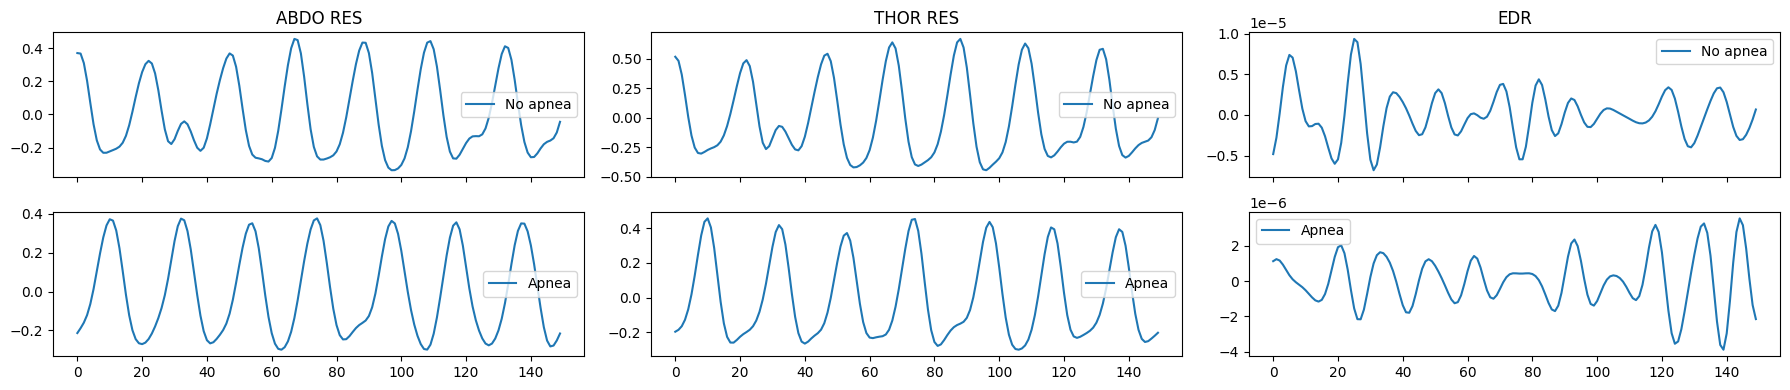

In [27]:
first_nonapnea = np.random.choice(np.where(label == 0)[0], size=1)[0]
first_apnea = np.random.choice(np.where(label == 1)[0], size=1)[0]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 4), sharex=True)

axes[0, 0].set_title("ABDO RES")
axes[0, 1].set_title("THOR RES")
axes[0, 2].set_title("EDR")

sns.lineplot(splitted_data[first_nonapnea][0], ax=axes[0, 0], label='No apnea')
sns.lineplot(splitted_data[first_nonapnea][1], ax=axes[0, 1], label='No apnea')
sns.lineplot(splitted_data[first_nonapnea][2], ax=axes[0, 2], label='No apnea')

sns.lineplot(splitted_data[first_apnea][0], ax=axes[1, 0], label='Apnea')
sns.lineplot(splitted_data[first_apnea][1], ax=axes[1, 1], label='Apnea')
sns.lineplot(splitted_data[first_apnea][2], ax=axes[1, 2], label='Apnea')


fig.tight_layout()
plt.show()

In [28]:
raise NotImplementedError() # 

NotImplementedError: 

# Multiprocess data preparing

In [ ]:
all_record = {}

for path in shhs1_xmls + shhs2_xmls:
    record = path[path.rfind("/") + 1:path.rfind("-nsrr.xml")]
    all_record[record] = [None, path]

for path in shhs1_edfs + shhs2_edfs:
    record = path[path.rfind("/") + 1:path.rfind(".edf")]
    all_record[record][0] = path


all_record = pd.DataFrame(all_record).T
all_record.index.name = 'Record'
all_record = all_record.rename(columns={0: 'EDF_path', 1: 'XML_path'})
all_record.reset_index(inplace=True)
all_record

In [ ]:
# remove missing records with missing channel (must contain SpO2, HR, OX stat)
remove_rows = []
for i, row in tqdm(all_record.iterrows(), total=len(all_record)):
    if row['EDF_path'] is None or row['XML_path'] is None:
        remove_rows.append(i)
        continue
    edf = get_edf(row['EDF_path'], SELECTED_CHANNELS, preload=False)
    if len(edf.ch_names) < 3: 
        remove_rows.append(i)
        continue

all_record.drop(index=remove_rows, inplace=True)
all_record

In [ ]:
def read_and_process(row):
    record = row['Record']
    edf_path = row['EDF_path']
    xml_path = row['XML_path']
    
    edf = get_edf(edf_path, SELECTED_CHANNELS, preload=True)
    
    anno = create_annotation(xml_path, edf.info['meas_date'], SELECTED_CHANNELS)
    edf.set_annotations(anno, emit_warning=False)
    
    dataa, long_bads = interpolate_bad_samples(edf)
    
    dataa[0] = sub_mean(dataa[0]) # SpO2
    dataa[1] = standardize(dataa[1])
    
    splitted_data = split_array(dataa, 1, SINGLE_ANNOT)

    onset, offset = get_onset_offset(edf.annotations, 'apnea')
    label = assign_apnea(onset, offset, splitted_data.shape[0], splitted_data.shape[2])
    # on_pred, off_pred = detect_desaturation_events(SpO2)
    
    # reuse apnea assignment to ignore long bads signal
    if len(long_bads) != 0:
        invalid_segments = assign_apnea(long_bads[:, 0], long_bads[:, 1], splitted_data.shape[0], splitted_data.shape[-1])
    else:
        invalid_segments = np.zeros(len(splitted_data))
    
    return record, invalid_segments, splitted_data, label

# Train/test split

## Stratify split on AHI

In [ ]:
shhs1_csv = pd.read_csv(os.path.join(BASE_DB_PATH, '../datasets/shhs1-dataset-0.21.0.csv'), usecols=['nsrrid', 'pptid','ahi_a0h3a'])
shhs1_csv['nsrrid'] = "shhs1-" + shhs1_csv['nsrrid'].astype('str')
shhs2_csv = pd.read_csv(os.path.join(BASE_DB_PATH, '../datasets/shhs2-dataset-0.21.0.csv'), usecols=['nsrrid', 'pptid','ahi_a0h3a'], encoding_errors='replace')
shhs2_csv['nsrrid'] = "shhs2-" + shhs2_csv['nsrrid'].astype('str')

csv_df = pd.concat([shhs1_csv, shhs2_csv], ignore_index=True)
csv_df.rename(columns={'nsrrid': 'Record'}, inplace=True)
csv_df

In [ ]:
bins = [-float('inf'), 5, 15, 30, float('inf')]  # Define bins for ranges
labels = ['none', 'mild', 'moderate', 'severe']  # Corresponding labels

csv_df['ahi_label'] = pd.cut(csv_df['ahi_a0h3a'], bins=bins, labels=labels, right=False)
csv_df

In [ ]:
all_record = pd.merge(all_record, csv_df, how='left', on='Record')
all_record

In [ ]:
RANDOM_STATE = 1

In [ ]:
all_record = all_record.sample(frac=SMALL_PORTION, random_state=RANDOM_STATE)
all_record

In [ ]:
shhs2_records = all_record[all_record['Record'].str.startswith('shhs2')]

train_records, test_records = train_test_split(shhs2_records['Record'], test_size=0.3, 
                                                random_state=RANDOM_STATE, 
                                                stratify=shhs2_records['ahi_label']) # should use AHI
test_records = pd.concat([test_records, all_record[all_record['Record'].str.startswith('shhs1')]['Record']])

In [ ]:
train_records, test_records

In [ ]:
from collections import defaultdict
window_df = defaultdict(list)

for _, row in tqdm(all_record.iterrows(), total=len(all_record)):
    record, invalid_segments, splitted_data, label = read_and_process(row)
    
    for j in range(HALF_SEGMENTS, len(splitted_data) - HALF_SEGMENTS):
        if invalid_segments[j] == 0:
            x = splitted_data[j-HALF_SEGMENTS:j+HALF_SEGMENTS+1]
            x = np.transpose(x, (0, 2, 1))
            x = x.reshape(-1, 2)
            
            y = label[j]
            
            window_df['Record'].append(record)
            window_df['Segment'].append(x)
            window_df['Label'].append(y)
            
window_df = pd.DataFrame(window_df)
window_df

In [ ]:
test_window_df = window_df[window_df['Record'].isin(test_records)]
window_df = window_df[window_df['Record'].isin(train_records)]
len(window_df), len(test_window_df)

In [ ]:
window_df = window_df.sample(frac=1, random_state=RANDOM_STATE) # shuffle
zero_df = window_df[window_df['Label'] == 0]
one_df = window_df[window_df['Label'] == 1]
len(one_df), len(zero_df)

## Prepare with balanced bootstrapping

In [ ]:
n_datasets = len(zero_df) // len(one_df)
sub_datasets = []
for i in range(n_datasets):
    start = i * len(one_df)
    stop = min((i + 1) * len(one_df), len(zero_df))
    
    subset = pd.concat([zero_df.iloc[start:stop], one_df], axis=0)

    sub_datasets.append(subset)
    
sub_datasets[0], len(sub_datasets)

In [ ]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from an integer or list of integers."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def serialize_example(ext, label, name=None):
    """Serialize the X and y data into a TFRecord example."""
    feature = {'ext': _float_feature(ext.flatten())}
    
    if label is not None:
        feature['label'] = _int64_feature(label.flatten())
    if name is not None:
        feature['name'] = _bytes_feature(name)
        
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

In [ ]:
OPTIONS = tf.io.TFRecordOptions(compression_type="GZIP")

In [ ]:
def process_row(row):
    record = row['Record']
    x = row['Segment']
    y = row['Label']
    
    return serialize_example(
                x, 
                np.array([y]), 
                # name=record
            )

def write_to_tfrecord(queue, output_file):
    with tf.io.TFRecordWriter(output_file, options=OPTIONS) as writer:
        while True:
            item = queue.get()
            if item is None:  # Sentinel value to indicate end of data
                break
            writer.write(item)

def main(df: pd.DataFrame, save_name, test=False, num_processes=None, verbose=True):
    num_processes = mp.cpu_count() - 4 if num_processes is None else num_processes

    # Create a queue and writer process only if multiprocessing is enabled
    if num_processes > 1:
        pool = mp.Pool(processes=num_processes)

        # Create a multiprocessing queue for communication between processes
        manager = mp.Manager()
        queue = manager.Queue()

        # Start the TFRecord writer process
        writer_process = mp.Process(target=write_to_tfrecord, args=(queue, save_name))
        writer_process.start()

        # Process rows in parallel
        total_data = 0
        total_removed_records = 0

        iterator = pool.imap(process_row, (row for _, row in df.iterrows()))
        if verbose:
            iterator = tqdm(iterator, total=len(df))

        for result in iterator:
            example = result
            queue.put(example)
            total_data += 1

        # Signal the writer process to finish
        queue.put(None)
        writer_process.join()

        pool.close()
        pool.join()

    else:
        # Single-process mode
        examples = []
        total_data = 0
        total_removed_records = 0

        iterator = (process_row(row) for _, row in df.iterrows())
        if verbose:
            iterator = tqdm(iterator, total=len(df))

        for result in iterator:
            if result is None:
                total_removed_records += 1
                continue
            examples.append(result)
            total_data += 1

        # Write data directly to TFRecord in single-process mode
        output_file = os.path.join(TO_PATH, save_name)
        with tf.io.TFRecordWriter(output_file, options=OPTIONS) as writer:
            for example in examples:
                writer.write(example)

    return f"File {save_name}, total segments: {total_data}, removed records: {total_removed_records}"

In [ ]:
for i, subset in enumerate(sub_datasets):
    train_set, validation_set = train_test_split(subset, test_size=0.2, 
                                                    random_state=RANDOM_STATE)
    names = ["train", "val"]
    if SMALL_PORTION != 1:
        names = [n + "_sub" for n in names]
    names = [f"{n}_part_{i}.tfrecord" for n in names]
    
    if len(train_set):
        result = main(train_set, os.path.join(TO_PATH, names[0]), num_processes=mp.cpu_count() - 2)
        print(result)
    
    if len(validation_set):
        result = main(validation_set, os.path.join(TO_PATH, names[1]), num_processes=mp.cpu_count() - 2)
        print(result)

In [ ]:
if len(test_window_df):
    result = main(test_window_df[test_window_df['Record'].str.startswith('shhs1')], os.path.join(TO_PATH, "test_1.tfrecord"), num_processes=mp.cpu_count() - 2)
    result = main(test_window_df[test_window_df['Record'].str.startswith('shhs2')], os.path.join(TO_PATH, "test_2.tfrecord"), num_processes=mp.cpu_count() - 2)
    
    print(result)